# Zero-shot object detection with Meta's Segment Anything Model (SAM) on COCO 2017 validation split dataset

This project enables zero-shot object detection using Meta's SAM. 

SAM is a tool that is able to generate segmentation masks from any image. From these segmentations, we query the CoCa model to generate predictions on these masks. Afterwards, we check if these object prediction labels are present in the COCO 2017 dataset. If so, we compare the SAM masks to the ground truth bounding box. 

For this project, the ground truth is defined by the type of input image. 

| Input image                             | Ground truth      |
|-----------------------------------------|-------------------|
| Random image from COCO validation split | COCO Ground truth |
| User-uploaded                           | YOLO Prediction   |
| Default image                           | YOLO Prediction   |

From here, we compute the IOU of the SAM mask and the ground truth. For an IOU > 0.7, it is considered to be a correct prediction.

In [72]:
import cv2
import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

from pytriton.client import ModelClient

import os
from pathlib import Path
import random

### Helper functions

In [73]:
def show_image(image_array):
    # image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

In [74]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

### Generate SAM masks via pytriton server

SAM mask generator returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `stability_score` : an additional measure of mask quality

In [75]:
# Returns a list of dictionaries containing the info of each mask
def infer_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', model='SAM_h', init_timeout_s=600.0):
    with ModelClient(url, model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        outputs = client.infer_sample(image=image)
        segmentation = outputs['segmentation']
        #area = masks['area']
        masks = []
        for i in range(segmentation.shape[0]):
            masks.append({
                'segmentation': segmentation[i,:,:],
                'area': outputs['area'][i],
                'bbox': outputs['bbox'][i],
                'predicted_iou': outputs['predicted_iou'][i],
                'stability_score': outputs['stability_score'][i],
            })


        '''
        FORMAT:

        masks = [{
            'segmentation': ndarray,
            'area': numpy.float32,
            'bbox': ndarray,
            'predicted_iou': numpy.float,
            'stability_score': numpy.float
            
            
            ...more (k,v) pairs in next functions
        }]
        '''

        
        return image, masks

### Image input

Program is able to accept three types of image input.

- `Default`: Enter an empty string.
- `Random`: Enter the string "r".
- `User-uploaded`: Provide filepath to image or URL of image.

In [76]:
image_path = input("Enter image path, URL, 'r' for random, empty for default: ")

input_key = 0

if image_path == "":
    input_key = 0
    image_path = "images/aki_dog.jpg"

elif image_path == 'r':
    input_key = 2

else: # User uploaded image
    input_key = 1


### COCO Dataset

This project assumes that the COCO 2017 validation split images and the corresponding annotation files have been saved locally.

Inside the dataset folder, add another folder named `annotations` which has the `instances_val2017.json` file.

Set `coco_path` to point to the folder with the dataset images.

In [77]:
coco_path = '../val2017'
annotation_path = coco_path + '/annotations/instances_val2017.json'

In [78]:
# Init COCO object
coco = COCO(annotation_path)

# Get all category IDs
category_ids = coco.getCatIds()

# Load category info for each category_id
categories = coco.loadCats(category_ids)

# Extract the names of the categories into a list
category_names = {}
for category in categories:
    category_names.update({category['id'] : category['name']})



loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


### Get random image from COCO validation split, if input image type is random.

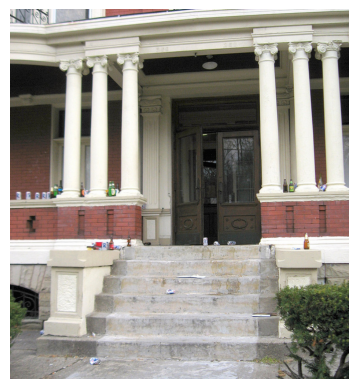

bottle
	segmentation
		[[507.9, 413.08, 508.87, 402.5, 509.59, 394.08, 509.35, 390.96, 510.55, 388.79, 510.79, 387.35, 515.12, 386.15, 515.12, 389.03, 515.6, 401.06, 516.8, 407.31, 518.0, 415.96]]
	area
		194.31179999999986
	iscrowd
		0
	image_id
		464689
	bbox
		[507.9, 386.15, 10.1, 29.81]
	category_id
		44
	id
		1492051
bottle
	segmentation
		[[201.92, 411.32, 209.48, 410.69, 209.48, 396.82, 206.33, 386.11, 203.81, 386.11, 201.29, 395.56, 201.29, 409.42]]
	area
		174.71474999999992
	iscrowd
		0
	image_id
		464689
	bbox
		[201.29, 386.11, 8.19, 25.21]
	category_id
		44
	id
		1493335
bottle
	segmentation
		[[479.44, 304.9, 480.74, 316.96, 471.79, 317.35, 471.27, 304.9, 472.83, 301.79, 473.48, 294.79, 474.13, 293.23, 476.98, 293.1, 477.76, 299.97]]
	area
		162.9917
	iscrowd
		0
	image_id
		464689
	bbox
		[471.27, 293.1, 9.47, 24.25]
	category_id
		44
	id
		1493837
bottle
	segmentation
		[[484.44, 294.86, 487.82, 294.86, 488.95, 301.19, 489.93, 304.14, 490.92, 316.1, 487.54, 316.81, 483

In [79]:
if input_key == 2:
    # Get random image from COCO
    image_ids = coco.getImgIds()
    random_image_id = random.choice(image_ids)
    image_info = coco.loadImgs(random_image_id)[0]
    random_image_path = coco_path + '/' + image_info['file_name']
    random_image = plt.imread(random_image_path)
    annotation_ids = coco.getAnnIds(imgIds=random_image_id)
    annotations = coco.loadAnns(annotation_ids)

    show_image(random_image)

    for a in annotations:
        idx = a['category_id']
        print(category_names[idx])
        pretty(a, 1)

    image_path = random_image_path

### Perform SAM segmentation

Call the SAM model from the PyTriton server.

In [80]:
image, masks = infer_model(image=image_path)

### Crop masks function

Crop each segmentation mask generated by SAM and save to the `cropped/` folder. 

The following details of the cropped mask are also added to the corresponding masks' dictionary.


- `filename`: filename of the cropped mask
- `cropped_img`: the cropped image (in tensor format)
- `mask_id`: unique identifier of the cropped mask

In [81]:
def process_masks(image, masks):
    # Crop and save each segmented mask in cropped/ folder

    # Clear cropped folder before saving new crops
    for filename in os.listdir('cropped/'):
        file_path = os.path.join('cropped/', filename)
    
        # Check if the path is a file (not a subdirectory)
        if os.path.isfile(file_path):
            # Delete the file
            os.remove(file_path)
    
    i=0
    for mask in masks:

        x, y, w, h = mask['bbox']
        
        # Crop segmentation
        cropped_img = image[y:y+h, x:x+w].copy()
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        
        filename = '%i.jpg'%i

        # Add details of the cropped image to the corresponding masks' dictionary.
        mask.update({'filename': filename})
        mask.update({'cropped_img': cropped_img})
        mask.update({'mask_id': i})

        # Save image
        path = Path('cropped/')
        filepath = os.path.join(path, filename)

        cv2.imwrite(filepath, cropped_img)

        i+=1

Call the `process_masks` function.

In [82]:
process_masks(image, masks)

## Model pytriton calls

### OpenCLIP PyTriton call
Generate an OpenCLIP prediction from an input image.

*code from Doc R*

In [83]:
def openclip_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', openclip_model='OpenClip_b32', coca_model='CoCa_l14', init_timeout_s=600.0):
    with ModelClient(url, openclip_model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "index":
                continue
            else:
                label = v.tobytes().decode('utf-32')
                return label

### CoCa pytriton call
Generate a CoCa prediction from an input image.

*code from Doc R*

In [84]:
def coca_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', coca_model='CoCa_l14', init_timeout_s=600.0):
    with ModelClient(url, coca_model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # logger.info(f"Running inference requests")
        outputs = client.infer_sample(image)
        # print(outputs)
        for k, v in outputs.items():
            coca_prediction = v.tobytes().decode('utf-32')
            # print(coca_prediction)
            return(coca_prediction)

### YOLOv8 pytriton call

This example shows how to run [Yolov8](https://docs.ultralytics.com/) by Ultralytics on a remote PyTriton server. Similar to the previous examples, the image will be loaded from client side and transmitted to the server over http for inference. The server returns the following:

* `bboxes` - an array of bounding boxes. Each item refers to detected object in MSCOCO 80 classes.
* `probs` - an array of probabilities for each detected object.
* `names` - a `|` - separated of names of detected objects.


*code from Doc R*

In [85]:
def yolo_model(url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
                outputs['names'] = names
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        return outputs   

### Per-mask CoCa Prediction

Query each mask and append CoCa prediction into the `masks` dictionary.

In [86]:
mask_files = os.listdir('cropped/')

for file in mask_files:
    for mask in masks:
        
        if str(mask['mask_id']) == file.strip('.jpg'):
            
            mask.update({'coca_pred': coca_model(image='cropped/'+file)})
            break
            

In [87]:
for mask in masks:
    print(mask['filename'], mask['coca_pred'])

0.jpg a building with a lot of steps leading up to it . 
1.jpg a close up picture of a concrete surface . 
2.jpg a tall white candle is lit on a table . 
3.jpg a picture of some steps that have been cleaned . 
4.jpg a tall white candle is lit on a table . 
5.jpg a tall white candle is lit on a table . 
6.jpg a picture of a forest with trees in the background . 
7.jpg a tall white candle sitting on top of a wooden table . 
8.jpg a brown brick wall with a white dot in the middle . 
9.jpg a black and white picture of a bottle . 
10.jpg a tall white candle sitting on top of a table . 
11.jpg a close - up of a tree in a courtyard . 
12.jpg a close - up image of a white paper . 
13.jpg a close - up picture of a person wearing a white shirt . 
14.jpg a picture of a bird flying in the sky . 
15.jpg a picture of a table and chairs . 
16.jpg a close up picture of a brick wall . 
17.jpg a red brick wall with a white brick wall . 
18.jpg a picture of a group of people standing next to each other 


### Check if CoCa prediction exists in the COCO dataset

In [88]:
def find_COCO_object(categories, coca_pred):
    categories_present = []
    for category in categories:
        # print(category, coca_pred)
        if category['name'] in coca_pred:
            categories_present.append({
                'name': category['name'],
                'category_id': category['id']
            })
    print(categories_present)
    return categories_present
        
        

Check if label is in COCO, append masks with CoCa predictions that are present in COCO into masks_copy.

In [89]:
for mask in masks:
    found = find_COCO_object(categories, mask['coca_pred'])

    if not bool(found):
        mask.update({'in_coco': False})
    else:
        mask.update({'in_coco': True})
        mask['coca_pred'] = found

masks_copy = []
for mask in masks:

    if mask['in_coco']:
        masks_copy.append(mask)

print(len(masks))
print(len(masks_copy))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'name': 'bottle', 'category_id': 44}]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[{'name': 'bird', 'category_id': 16}]
[{'name': 'chair', 'category_id': 62}]
[]
[]
[]
[]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[]
[{'name': 'cat', 'category_id': 17}]
[{'name': 'person', 'category_id': 1}, {'name': 'surfboard', 'category_id': 42}]
[{'name': 'person', 'category_id': 1}]
[]
[]
[{'name': 'bottle', 'category_id': 44}]
[]
[{'name': 'person', 'category_id': 1}]
[{'name': 'person', 'category_id': 1}]
[]
[{'name': 'car', 'category_id': 3}]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[{'name': 'person', 'category_id': 1}]
[{'name': 'person', 'category_id': 1}]
[{'name': 'person', 'category_id': 1}]
[{'name': 'person', 'category_id': 1}]
[{'name': 'bus', 'category_id': 6}]
[{'name': 'bowl', 'category_id': 51}]
[{'name': 'person', 'category_id': 1}]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]


### YOLOv8 Prediction
Put objects detected in the overall image by YOLOv8 in the list `yolo_predictions`.

In [90]:
# YOLO output serves as ground truth for user-uploaded images i.e images that do not come from the COCO 2017 val split.
yolo_output = yolo_model(image=image_path)

# Reformat yolo_output dictionary to a list of dictionaries with each item being a YOLOv8-detected object
# For easier, iteration with masks list
yolo_predictions = []
for i in range(len(yolo_output['names'])):
    object_dict = {
        'name': yolo_output['names'][i],
        'bboxes': yolo_output['bboxes'][i],
        'probs': yolo_output['probs'][i]
    }
    yolo_predictions.append(object_dict)

# YOLO bbox in format [x1 y1 x2 y2]
# Convert YOLO to [x y w h]
for p in yolo_predictions:
    for k, v in p.items():
        if k == 'bboxes':
            x1, y1, x2, y2 = v
            v[0] = x1 
            v[1] = y1
            v[2] = x2 - x1
            v[3] = y2 - y1
        print(k, v)
    

name bottle
bboxes [507.70258  387.26422   10.345947  28.625488]
probs 0.70155734
name bottle
bboxes [481.89746  294.34137    8.655518  22.644592]
probs 0.6585951
name bottle
bboxes [471.85693  294.02722    8.484253  23.60022 ]
probs 0.618706
name bottle
bboxes [121.67052   299.76147     7.6151733  25.779907 ]
probs 0.41101873
name bottle
bboxes [171.25002  393.33545    8.509949  23.613342]
probs 0.2802717
name bottle
bboxes [ 82.69659   296.1176      8.9135895  24.811157 ]
probs 0.27302247
name bottle
bboxes [201.69093  392.0962     7.850586  18.964722]
probs 0.26439416


### Compute IOU of GT
Ground truth differs based on input image type.

| Input image                             | Ground truth      |
|-----------------------------------------|-------------------|
| Random image from COCO validation split | COCO Ground truth |
| User-uploaded                           | YOLO Prediction   |
| Default image                           | YOLO Prediction   |

In [91]:
def compute_iou(bbox1, bbox2):
    print('Computing iou...')

    x1 = bbox1[0]
    y1 = bbox1[1]
    w1 = bbox1[2]
    h1 = bbox1[3]

    x2 = bbox2[0]
    y2 = bbox2[1]
    w2 = bbox2[2]
    h2 = bbox2[3]

    intersection_width = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_height = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection_area = intersection_width * intersection_height

    area_box1 = w1 * h1
    area_box2 = w2 * h2

    union_area = area_box1 + area_box2 - intersection_area

    iou = intersection_area / union_area

    print ('sam_box:', bbox1)
    print ('gt_box:', bbox2)

    return iou

### Overall Image IOU computation with YOLO as ground truth.

In [92]:
def sam_yolo(masks_copy, yolo_predictions):

    # For each mask, compute the IOU between YOLO prediction and CoCa prediction

    for mask in masks_copy:
        
        for prediction in yolo_predictions:
            if prediction['probs'] < 0.5: continue # Skip low-prob YOLO predicts

            coca_predictions = mask['coca_pred']

            for p in coca_predictions:

                print(type(coca_predictions), coca_predictions)
                print(p)
                print(prediction)
                
                sam_bbox = mask['bbox']
                yolo_bbox = prediction['bboxes']
                
                if yolo_bbox.size == 0: continue

                # Check if yolo_prediction is the same as coca_prediction
                print(prediction['name'], p['name'])

                if prediction['name'] == p['name']:
                    iou = compute_iou(sam_bbox, yolo_bbox)
                    
                    if p['iou'] < iou:
                        p['iou'] = iou

                    if iou >= 0.7:
                        show_image(mask['cropped_img'])

                    print(mask['mask_id'], '\t',mask['coca_pred'], prediction['name'], p['iou'])


### Overall Image IOU computation with COCO annotation as ground truth.

In [93]:
def sam_coco(masks_copy, coco_gt):
    for mask in masks_copy:
        
        for detection in coco_gt:
            
            coca_predictions = mask['coca_pred']

            for p in coca_predictions:
                
                sam_bbox = mask['bbox']
                coco_gt_bbox = detection['bbox']

                if detection['category_id'] == p['category_id']:
                    iou = compute_iou(sam_bbox, coco_gt_bbox)

                    if p['iou'] < iou:
                        p['iou'] = iou

                    if iou >= 0.7:
                        show_image(mask['cropped_img'])

                    print(mask['mask_id'], '\t',mask['coca_pred'], category_names.get(detection['category_id']), p['iou'])

### Call appopriate IOU computation function depending on ground truth. 

In [94]:
# Populate masks with iou = 0
for mask in masks_copy:
    coca_predictions = mask['coca_pred']

    for p in coca_predictions:
        p.update({'iou': 0.0})

    
# If input is user-uploaded or a default image
if input_key == 0 or input_key == 1:
    sam_yolo(masks_copy=masks_copy, yolo_predictions=yolo_predictions)

# If input is 'r' (random)
if input_key == 2:
    sam_coco(masks_copy=masks_copy, coco_gt=annotations)


    

Computing iou...
sam_box: [132  81  36 243]
gt_box: [507.9, 386.15, 10.1, 29.81]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [201.29, 386.11, 8.19, 25.21]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [471.27, 293.1, 9.47, 24.25]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [481.49, 294.86, 9.43, 22.09]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [82.63, 296.49, 8.8, 23.93]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [119.93, 300.09, 8.45, 25.02]
9 	 [{'name': 'bottle', 'category_id': 44, 'iou': 0.0}] bottle 0.0
Computing iou...
sam_box: [132  81  36 243]
gt_box: [69.67, 307.79, 5.98, 18.37]
9 	 [{'name': 'bottle', 'cate

For each mask, find coca_prediction with highest IOU

In [95]:
# For each mask, find coca_prediction with highest IOU

highest_iou = None
for mask in masks_copy:
    
    prediction = mask['coca_pred']
    temp = 0.0
    # print(prediction)
    for a in prediction:
        # print(a)
        if a['iou'] > temp:
            temp = a['iou']
    
    for a in prediction:
        if a['iou'] == temp:
            highest_iou = a

    mask.update({
        'name': highest_iou['name'],
        'category_id': highest_iou['category_id'],
        'iou': highest_iou['iou']
    })
    

for mask in masks_copy:
    print(mask['mask_id'], mask['category_id'], mask['name'], mask['bbox'], mask['iou'])


9 44 bottle [132  81  36 243] 0.048740861088545896
13 1 person [ 0  0 65 26] 0.0
14 16 bird [ 64 417 125  29] 0.0
15 62 chair [459 415  79  32] 0.0
23 1 person [285 205  48 202] 0.0
28 17 cat [358 210  74 196] 0.0
29 42 surfboard [79  0 54 23] 0.0
30 1 person [  0 442  69  48] 0.0
33 44 bottle [432 393 153  46] 0.03262838943970086
35 1 person [516  70  23  50] 0.0
36 1 person [229  75 354  41] 0.0
38 3 car [137 602  19  13] 0.0
40 1 person [429 531  35  35] 0.0
43 1 person [ 53 603 412  36] 0.0
46 1 person [225 150  36 195] 0.0
47 1 person [293 216  31 118] 0.0
48 1 person [136   0  28  15] 0.0
49 1 person [534 339  12  47] 0.0
50 6 bus [464 448  66 109] 0.0
51 51 bowl [382 362  28  18] 0.0
52 1 person [123 173  16  46] 0.0
55 1 person [572 149  13  50] 0.0
58 1 person [464 537  23  33] 0.0
59 3 car [352 401  10   8] 0.0
66 1 person [575 217  10  90] 0.0
67 1 person [192 411  23  21] 0.0
69 3 car [269 484  16   9] 0.0
72 3 car [147 403  11   8] 0.0
74 41 skateboard [  0 398 227  42] 0.

### My Prediction

In [96]:
def draw_figure(image, masks):
    # Plotting
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    for mask in masks:
        if mask['iou'] > 0.7:
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{mask['name']} iou:{mask['iou']:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

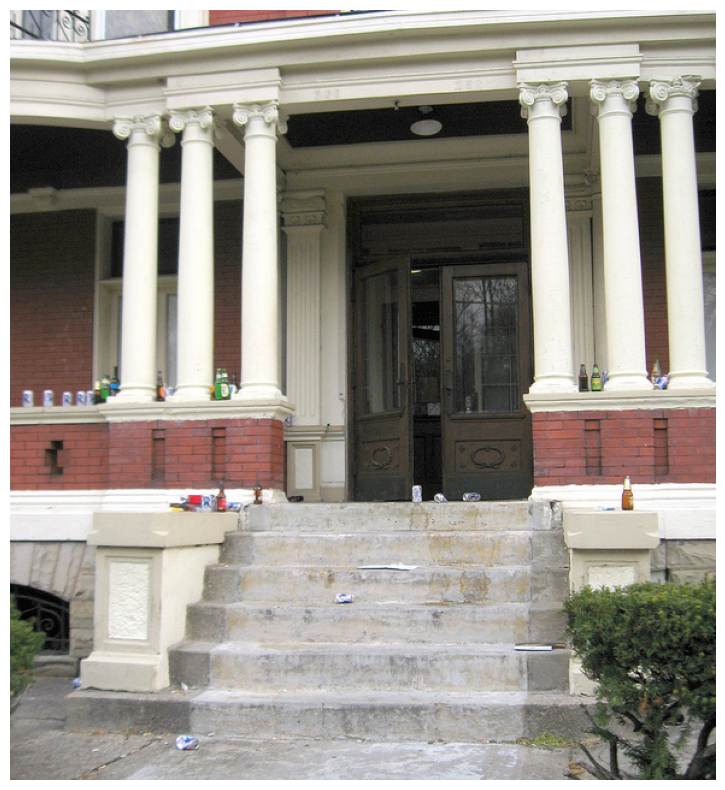

In [97]:
draw_figure(image, masks_copy)

### YOLO Prediction

In [98]:
def draw_yolo(url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
                outputs['names'] = names
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v

        
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
        


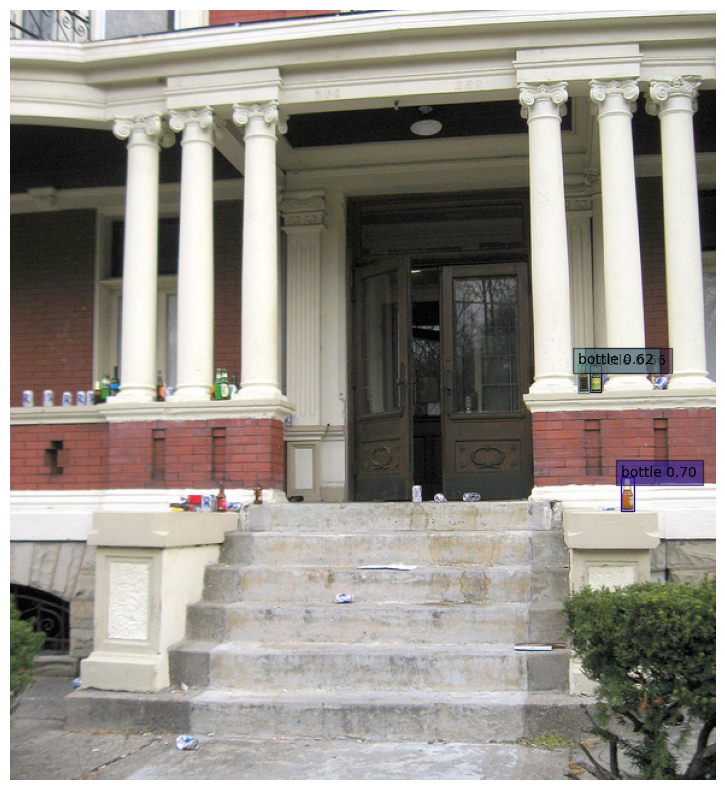

In [99]:
draw_yolo(image=image_path)

### COCO Ground Truth

In [100]:
def draw_coco(image_path=image_path, annotations=annotations):
    # image = plt.imread(image_path)
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    
    for a in annotations:
        x, y, w, h = a['bbox']
        color = np.random.rand(3,)
        rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
        ax.add_patch(rect)
        # use the color and add transparency of 0.5
        color = np.append(color, 0.5)
        # add text with white background
        ax.text(x, y, f"{category_names[a['category_id']]}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

    

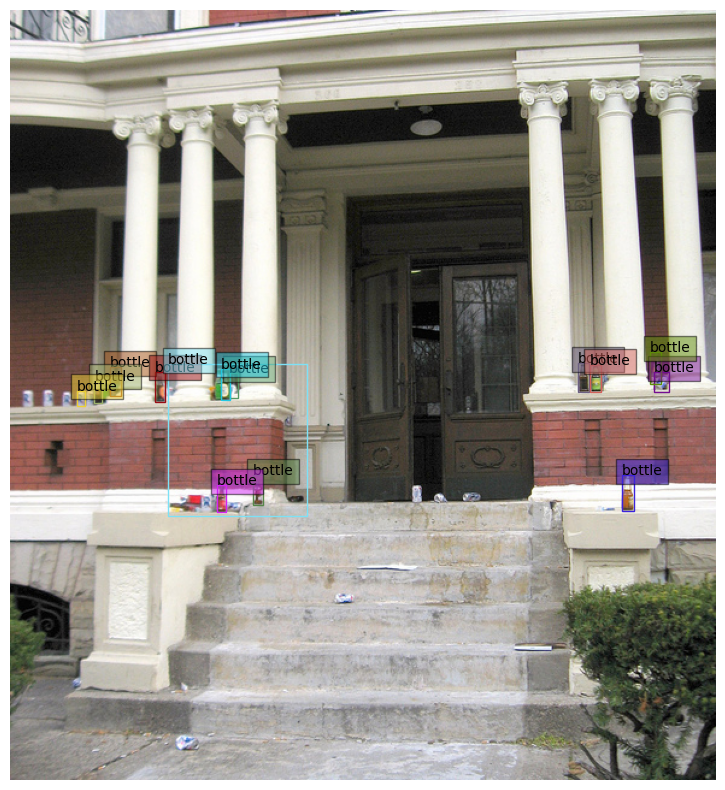

In [101]:
if input_key == 2:
    draw_coco()